In [22]:
import json
from collections import OrderedDict
from pathlib import Path
from pprint import pprint

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

cwd_path = Path.cwd()

dataset = "CIFAR10"  # CIFAR10, CIFAR100, SVHN
v_type = "mingd"  # mingd, rand

mpl.rcParams['text.latex.preamble'] = r'\usepackage{times}'

plt.rcParams.update({
    "text.usetex": True,
})

# Sizes
SMALL_SIZE = 14
MEDIUM_SIZE = SMALL_SIZE + 1
BIGGER_SIZE = MEDIUM_SIZE + 1
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsi ze of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE - 5)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


In [23]:
hdf_output_parent_dir_path = cwd_path / "hdf"
hdf_output_path = hdf_output_parent_dir_path / f"{dataset}_{v_type}.h5"


In [24]:
results_df = pd.read_hdf(str(hdf_output_path), v_type)

rename_dict = {  # ! Change mapping
    "threat_model": "Threat Model",
    "teacher": "Source (CIFAR10 train set)",
    # "distillation": "Distillation",
    # "extract-label": "Label-Query",
    # "extract-logit": "Logit-Query",
    # "zero-shot": "Zero-Shot Learning",
    # "fine-tune": "Fine-Tuning",
    # "pre-act-18": "Diff. Architecture",
    "independent": "Independent (CIFAR10 test set)",
    "data-normalization": "Data Normalization",
    "min-max--1-and-1": "Min-max -1 and 1",
    "normalization-without-mean": "Normalization without mean",
    "normalization-without-std": "Normalization without std",
    "rgb-grayscale": "RGB Grayscale",
}

plot_df = (results_df.rename(columns=rename_dict).replace(rename_dict)
           .query('(m >= 5)')
           )

# ! Fix: ValueError: cannot reindex on an axis with duplicate labels
plot_df[plot_df.index.duplicated()]
plot_df.reset_index(inplace=True)


In [25]:
# read & prepare data
performance_json_path = cwd_path / "fe_performance.json"

model_label_col = [
    "Source",
    "Independent",
    "Data Normalization",
    "Min-max -1 and 1",
    "Normalization without mean",
    "Normalization without std",
    "RGB Grayscale",
]

ratio_labels = [
    "Data Norm.",
    "Min-max",
    "w/o mean",
    "w/o std",
    "grayscale",
]

model_label__train_acc_map = OrderedDict({
    "Source": pd.Series([], dtype='float64'),
    "Independent": pd.Series([], dtype='float64'),
})

model_label__test_acc_map = OrderedDict({
    "Source": pd.Series([], dtype='float64'),
    "Independent": pd.Series([], dtype='float64'),
})

train_acc_list = []
test_acc_list = []

with open(str(performance_json_path), "r") as outfile:
    data = json.load(outfile)
    col_ind = 2
    for model_label, acc_dict in data.items():
        train_acc = acc_dict["train_acc"]
        train_acc_list.append(train_acc)
        train_val_list = [None] * 3
        train_val_list += [train_acc] * 2

        test_acc = acc_dict["test_acc"]
        test_acc_list.append(test_acc)
        test_val_list = [None] * 47
        test_val_list += [test_acc] * 2

        model_label__train_acc_map[model_label_col[col_ind]] = pd.Series(train_val_list)
        model_label__test_acc_map[model_label_col[col_ind]] = pd.Series(test_val_list)
        col_ind += 1

# pprint(model_label__train_acc_map)


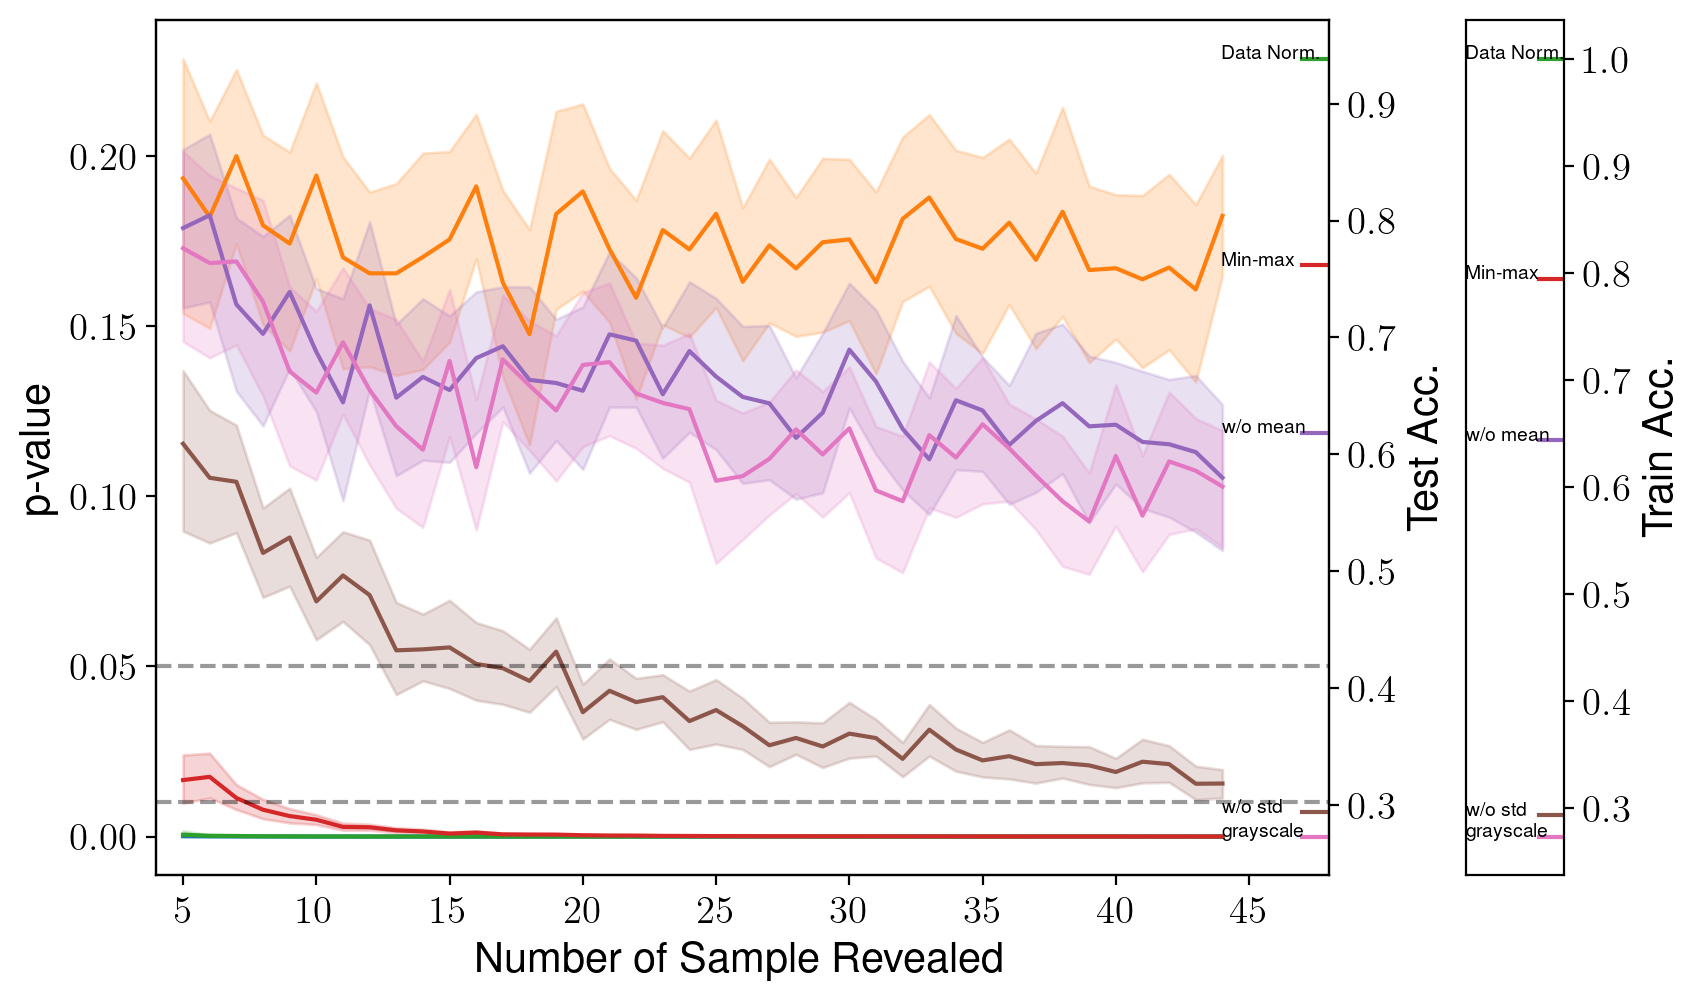

In [26]:
fig, axs = plt.subplots(nrows=1, ncols=2, gridspec_kw={'width_ratios': [12, 1]},
                        figsize=(8.5, 5), dpi=200)
g = sns.lineplot(x="m", y="p_value", hue="Threat Model", data=plot_df, ax=axs[0], ci=99)
g.axhline(0.05, ls='--', color="black", alpha=0.4)
g.axhline(0.01, ls='--', color="black", alpha=0.4)
g.set_xlabel("Number of Sample Revealed")
g.set_ylabel("p-value")
axs[0].get_legend().remove()

test_acc_axes = axs[0].twinx()
test_acc_axes.set_ylabel("Test Acc.")
test_acc_axes.set_xlim(4, 48)
_ = sns.lineplot(data=model_label__test_acc_map, ax=test_acc_axes, dashes=False)
test_acc_axes.get_legend().remove()

for ind, test_acc in enumerate(test_acc_list):
    if model_label in ["Source",    "Independent", ]:
        continue
    label_x = 44
    test_acc_axes.annotate(
        ratio_labels[ind],
        xy=(label_x, test_acc),
        fontsize=7,
    )

axs[1].yaxis.set_label_position("right")
axs[1].yaxis.tick_right()
axs[1].set_xticks([])
axs[1].set_ylabel("Train Acc.")
axs[1].set_xlim(0, 4)
_ = sns.lineplot(data=model_label__train_acc_map, ax=axs[1], dashes=False)
axs[1].get_legend().remove()

for ind, train_acc in enumerate(train_acc_list):
    if model_label in ["Source",    "Independent", ]:
        continue
    label_x = 0
    axs[1].annotate(
        ratio_labels[ind],
        xy=(label_x, train_acc),
        fontsize=7,
    )


fig.tight_layout(pad=0.5)


Text(44, 0.8, '8:2')

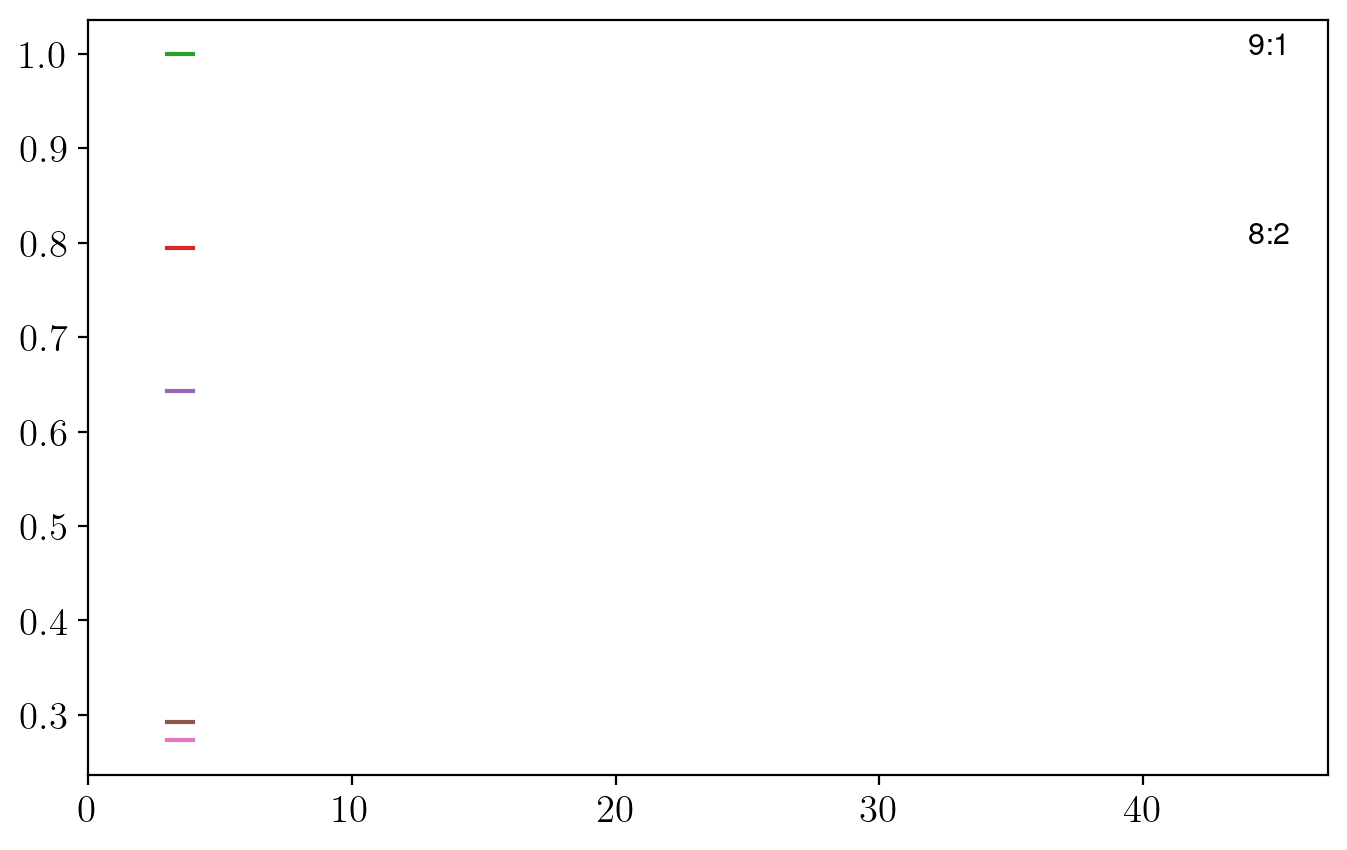

In [27]:
fig, ax = plt.subplots(figsize=(8, 5), dpi=200)
g = sns.lineplot(data=model_label__train_acc_map, ax=ax, dashes=False)
ax.get_legend().remove()
g.set_xlim(0, 47)

g.annotate(
    "9:1",
    xy=(44, 1),
    fontsize=11,
)
g.annotate(
    "8:2",
    xy=(44, 0.8),
    fontsize=11,
)
